In [12]:
cfg = '../cfg/custom-yolov4-detector.cfg'
wt = '../backup/custom-yolov4-detector_4000.weights'
#whatever

In [14]:
# import torch
import numpy as np
x = np.ones((416, 416, 3))
import cv2
cv2.imwrite('hmm.png', x)

True

In [16]:
import demo_darknet2onnx as d

In [18]:
d.main(cfg, 'whatever.txt', wt, 'hmm.png', 1)

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     64  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  64
    3 route  1
    4 conv     64  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  64
    5 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    6 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    7 shortcut 4
    8 conv     64  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  64
    9 route  8 2
   10 conv     64  1 x 1 / 1   208 x 208 x 128   ->   208 x 208 x  64
   11 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
   12 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   13 route  11
   14 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   15 conv     64  1 x 1 / 1   104 x 104 x  64   ->   104 x 104 x  64
   16 conv     64  3 x 3 / 1

Onnx model exporting done
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     64  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  64
    3 route  1
    4 conv     64  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  64
    5 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    6 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    7 shortcut 4
    8 conv     64  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  64
    9 route  8 2
   10 conv     64  1 x 1 / 1   208 x 208 x 128   ->   208 x 208 x  64
   11 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
   12 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   13 route  11
   14 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   15 conv     64  1 x 1 / 1   104 x 104 x  64   ->   104 x 104 x  64
  

Loading weights from ../backup/custom-yolov4-detector_4000.weights... Done!
Onnx model exporting done
The model expects input shape:  [1, 3, 416, 416]
Shape of the network input:  (1, 3, 416, 416)
-----------------------------------
       max and argmax : 0.000103
                  nms : 0.000055
Post processing total : 0.000158
-----------------------------------
save plot results to predictions_onnx.jpg


In [20]:
import tensorrt as trt

TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
trt_runtime = trt.Runtime(TRT_LOGGER)
def build_engine(onnx_path, shape = [1,3, 416,416]):

   """
   This is the function to create the TensorRT engine
   Args:
      onnx_path : Path to onnx_file. 
      shape : Shape of the input of the ONNX file. 
  """
   with trt.Builder(TRT_LOGGER) as builder, builder.create_network(1) as network, builder.create_builder_config() as config, trt.OnnxParser(network, TRT_LOGGER) as parser:
       config.max_workspace_size = (1 << 30)
       with open(onnx_path, 'rb') as model:
           parser.parse(model.read())
       network.get_input(0).shape = shape
       engine = builder.build_engine(network, config)
       print('hmmm')
       return engine

def save_engine(engine, file_name):
   buf = engine.serialize()
   with open(file_name, 'wb') as f:
       f.write(buf)
def load_engine(trt_runtime, plan_path):
   with open(plan_path, 'rb') as f:
       engine_data = f.read()
   engine = trt_runtime.deserialize_cuda_engine(engine_data)
   return engine

In [22]:
ez = build_engine('yolov4_1_3_416_416_static.onnx')

/home/caffeinatedkronos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Use set_memory_pool_limit instead.
  
/home/caffeinatedkronos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Use build_serialized_network instead.


hmmm


In [24]:
print(ez)

In [26]:
save_engine(ez, 'trtez_416')

In [28]:
ez = load_engine(trt_runtime, 'trtez_416')

In [30]:
import tensorrt as trt
import numpy as np
import os

import pycuda.driver as cuda
import pycuda.autoinit



class HostDeviceMem(object):
    def __init__(self, host_mem, device_mem):
        self.host = host_mem
        self.device = device_mem

    def __str__(self):
        return "Host:\n" + str(self.host) + "\nDevice:\n" + str(self.device)

    def __repr__(self):
        return self.__str__()

class TrtModel:
    
    def __init__(self,engine_path,max_batch_size=1,dtype=np.float32):
        
        self.engine_path = engine_path
        self.dtype = dtype
        self.logger = trt.Logger(trt.Logger.WARNING)
        self.runtime = trt.Runtime(self.logger)
        self.engine = self.load_engine(self.runtime, self.engine_path)
        self.max_batch_size = max_batch_size
        self.inputs, self.outputs, self.bindings, self.stream = self.allocate_buffers()
        self.context = self.engine.create_execution_context()

                
                
    @staticmethod
    def load_engine(trt_runtime, engine_path):
        trt.init_libnvinfer_plugins(None, "")             
        with open(engine_path, 'rb') as f:
            engine_data = f.read()
        engine = trt_runtime.deserialize_cuda_engine(engine_data)
        return engine
    
    def allocate_buffers(self):
        
        inputs = []
        outputs = []
        bindings = []
        stream = cuda.Stream()
        
        for binding in self.engine:
            size = trt.volume(self.engine.get_binding_shape(binding)) * self.max_batch_size
            host_mem = cuda.pagelocked_empty(size, self.dtype)
            device_mem = cuda.mem_alloc(host_mem.nbytes)
            
            bindings.append(int(device_mem))

            if self.engine.binding_is_input(binding):
                inputs.append(HostDeviceMem(host_mem, device_mem))
            else:
                outputs.append(HostDeviceMem(host_mem, device_mem))
        
        return inputs, outputs, bindings, stream
       
            
    def __call__(self,x:np.ndarray,batch_size=1):
        
        x = x.astype(self.dtype)
        
        np.copyto(self.inputs[0].host,x.ravel())
        
        for inp in self.inputs:
            cuda.memcpy_htod_async(inp.device, inp.host, self.stream)
        
        self.context.execute_async(batch_size=batch_size, bindings=self.bindings, stream_handle=self.stream.handle)
        for out in self.outputs:
            cuda.memcpy_dtoh_async(out.host, out.device, self.stream) 
            
        
        self.stream.synchronize()
        return [out.host.reshape(batch_size,-1) for out in self.outputs]


        
        


In [32]:
import cv2
batch_size = 1
trt_engine_path = 'trtez_416'
model = TrtModel(trt_engine_path)
shape = model.engine.get_binding_shape(0)


data = cv2.imread('hmm.png')

(IN_IMAGE_W, IN_IMAGE_H) = (416, 416)
resized = cv2.resize(data, (IN_IMAGE_W, IN_IMAGE_H), interpolation=cv2.INTER_LINEAR)
img_in = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
img_in = np.transpose(img_in, (2, 0, 1)).astype(np.float32)
img_in = np.expand_dims(img_in, axis=0)
img_in /= 255.0
img_in = np.ascontiguousarray(img_in)
result = model(img_in,batch_size)

In [34]:
data.shape

(416, 416, 3)

In [36]:
%timeit result = model(img_in,batch_size)

18.1 ms ± 31.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
result[0].shape

(1, 42588)

In [38]:
trt_outputs = result
trt_outputs[0] = trt_outputs[0].reshape(1, -1, 1, 4)
trt_outputs[1] = trt_outputs[1].reshape(1, -1, 1)

In [39]:
import time
def nms_cpu(boxes, confs, nms_thresh=0.5, min_mode=False):
    # print(boxes.shape)
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    order = confs.argsort()[::-1]

    keep = []
    while order.size > 0:
        idx_self = order[0]
        idx_other = order[1:]

        keep.append(idx_self)

        xx1 = np.maximum(x1[idx_self], x1[idx_other])
        yy1 = np.maximum(y1[idx_self], y1[idx_other])
        xx2 = np.minimum(x2[idx_self], x2[idx_other])
        yy2 = np.minimum(y2[idx_self], y2[idx_other])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h

        if min_mode:
            over = inter / np.minimum(areas[order[0]], areas[order[1:]])
        else:
            over = inter / (areas[order[0]] + areas[order[1:]] - inter)

        inds = np.where(over <= nms_thresh)[0]
        order = order[inds + 1]
    
    return np.array(keep)

def post_processing(conf_thresh, nms_thresh, output):

    # anchors = [12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401]
    # num_anchors = 9
    # anchor_masks = [[0, 1, 2], [3, 4, 5], [6, 7, 8]]
    # strides = [8, 16, 32]
    # anchor_step = len(anchors) // num_anchors

    # [batch, num, 1, 4]
    box_array = output[0]
    # [batch, num, num_classes]
    confs = output[1]

    t1 = time.time()

    if type(box_array).__name__ != 'ndarray':
        box_array = box_array.cpu().detach().numpy()
        confs = confs.cpu().detach().numpy()

    num_classes = confs.shape[2]

    # [batch, num, 4]
    box_array = box_array[:, :, 0]

    # [batch, num, num_classes] --> [batch, num]
    max_conf = np.max(confs, axis=2)
    max_id = np.argmax(confs, axis=2)

    t2 = time.time()

    bboxes_batch = []
    for i in range(box_array.shape[0]):
       
        argwhere = max_conf[i] > conf_thresh
        l_box_array = box_array[i, argwhere, :]
        l_max_conf = max_conf[i, argwhere]
        l_max_id = max_id[i, argwhere]

        bboxes = []
        # nms for each class
        for j in range(num_classes):

            cls_argwhere = l_max_id == j
            ll_box_array = l_box_array[cls_argwhere, :]
            ll_max_conf = l_max_conf[cls_argwhere]
            ll_max_id = l_max_id[cls_argwhere]

            keep = nms_cpu(ll_box_array, ll_max_conf, nms_thresh)
            
            if (keep.size > 0):
                ll_box_array = ll_box_array[keep, :]
                ll_max_conf = ll_max_conf[keep]
                ll_max_id = ll_max_id[keep]

                for k in range(ll_box_array.shape[0]):
                    bboxes.append([ll_box_array[k, 0], ll_box_array[k, 1], ll_box_array[k, 2], ll_box_array[k, 3], ll_max_conf[k], ll_max_conf[k], ll_max_id[k]])
        
        bboxes_batch.append(bboxes)

    t3 = time.time()

    print('-----------------------------------')
    print('       max and argmax : %f' % (t2 - t1))
    print('                  nms : %f' % (t3 - t2))
    print('Post processing total : %f' % (t3 - t1))
    print('-----------------------------------')
    
    return bboxes_batch

In [40]:
bbox = post_processing(0.4, 0.6, result)

-----------------------------------
       max and argmax : 0.000277
                  nms : 0.000131
Post processing total : 0.000408
-----------------------------------


In [41]:
bbox

[[]]

In [42]:
def loc_det(img, boxes):
    img = np.copy(img)
    width = img.shape[1]
    height = img.shape[0]
    if (len(boxes) > 0):
        box = boxes[0]
        x1 = int(box[0] * width)
        y1 = int(box[1] * height)
        x2 = int(box[2] * width)
        y2 = int(box[3] * height)
        return [True, x1, y1, x2, y2]
    else:
        return [False, 0, 0, 0, 0]

In [43]:
_, x1, y1, x2, y2 = loc_det(data, bbox[0])

In [44]:
bgr = data
trtout = cv2.rectangle(bgr.astype(np.uint8).copy() ,(int(x1),int(y1)),(int(x2),int(y2)),(0,0,255),3)

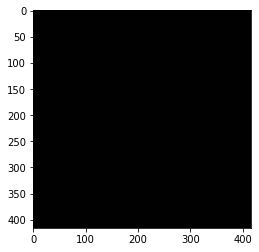

In [45]:
import matplotlib.pyplot as plt
plt.imshow(trtout)